## Table of Contents
- [Introduction](#intro)
- [Methodology and Data Sources](#methodology)

**Acquiring data**
- [Scrape locations data from Wikipedia](#locations_data)
- [Geocode neighborhoods](#geopy)
- [Get restaurants of different cuisines from Foursquare API](#foursquare)

**Exploring the data**
- [Visualise the top restaurant cuisines of each neighborhood](#top_cuisines)

**Clustering the data**
- [K-means clustering](#k-means)
- [Conclusion](#conclusion)

----

<a id='intro'></a>
## Introduction

Malaysia is a multi-racial country. Malay, Chinese and Indians make up the bulk of our nation's population, followed by foreign nationals from neighboring South-East Asian countries as well as those from further away continents.

This exercise is simple - I want to look at **how Malaysia's neighborhoods in Greater Kuala Lumpur vary in restaurant cuisine diversity**. This analysis may shed some light on the racial diversity of neighborhoods, but it by no means is able to paint an accurate picture of racial composition, due to the fact that supply and demand knows no greographical bounds. Nevertheless, the analysis may serve as a high-level starting point to gauge racial diversity as a function of restaurant cuisine diversity. 

----

<a id='methodology'></a>
## Methodology and Data Sources

The analysis studies the characteristics of neighborhoods in Greater Kuala Lumpur, Malaysia in terms of their restaurant cuisine offerings. As such, I use a clustering methodology to group neighborhoods that are similar in the types of cuisines that their respective restaurants are offering. **K-means clustering** is used for this analysis. 

Before running the clustering algorithm, I would need to obtain data. These include:

- **Locations data**: Neighborhoods in Greater Kuala Lumpur and their coordinates.
- **Restaurant cuisine data**: Restaurants of different cuisines in each neighborhood.

---

<a id='locations_data'></a>
## Acquiring locations data

Neighborhoods of Selangor are scraped from Wikipedia. The [page](https://en.wikipedia.org/wiki/Selangor) has a table of districts and subdistricts for Selangor, which along with Kuala Lumpur, makes up Greater Kuala Lumpur. 

See below.

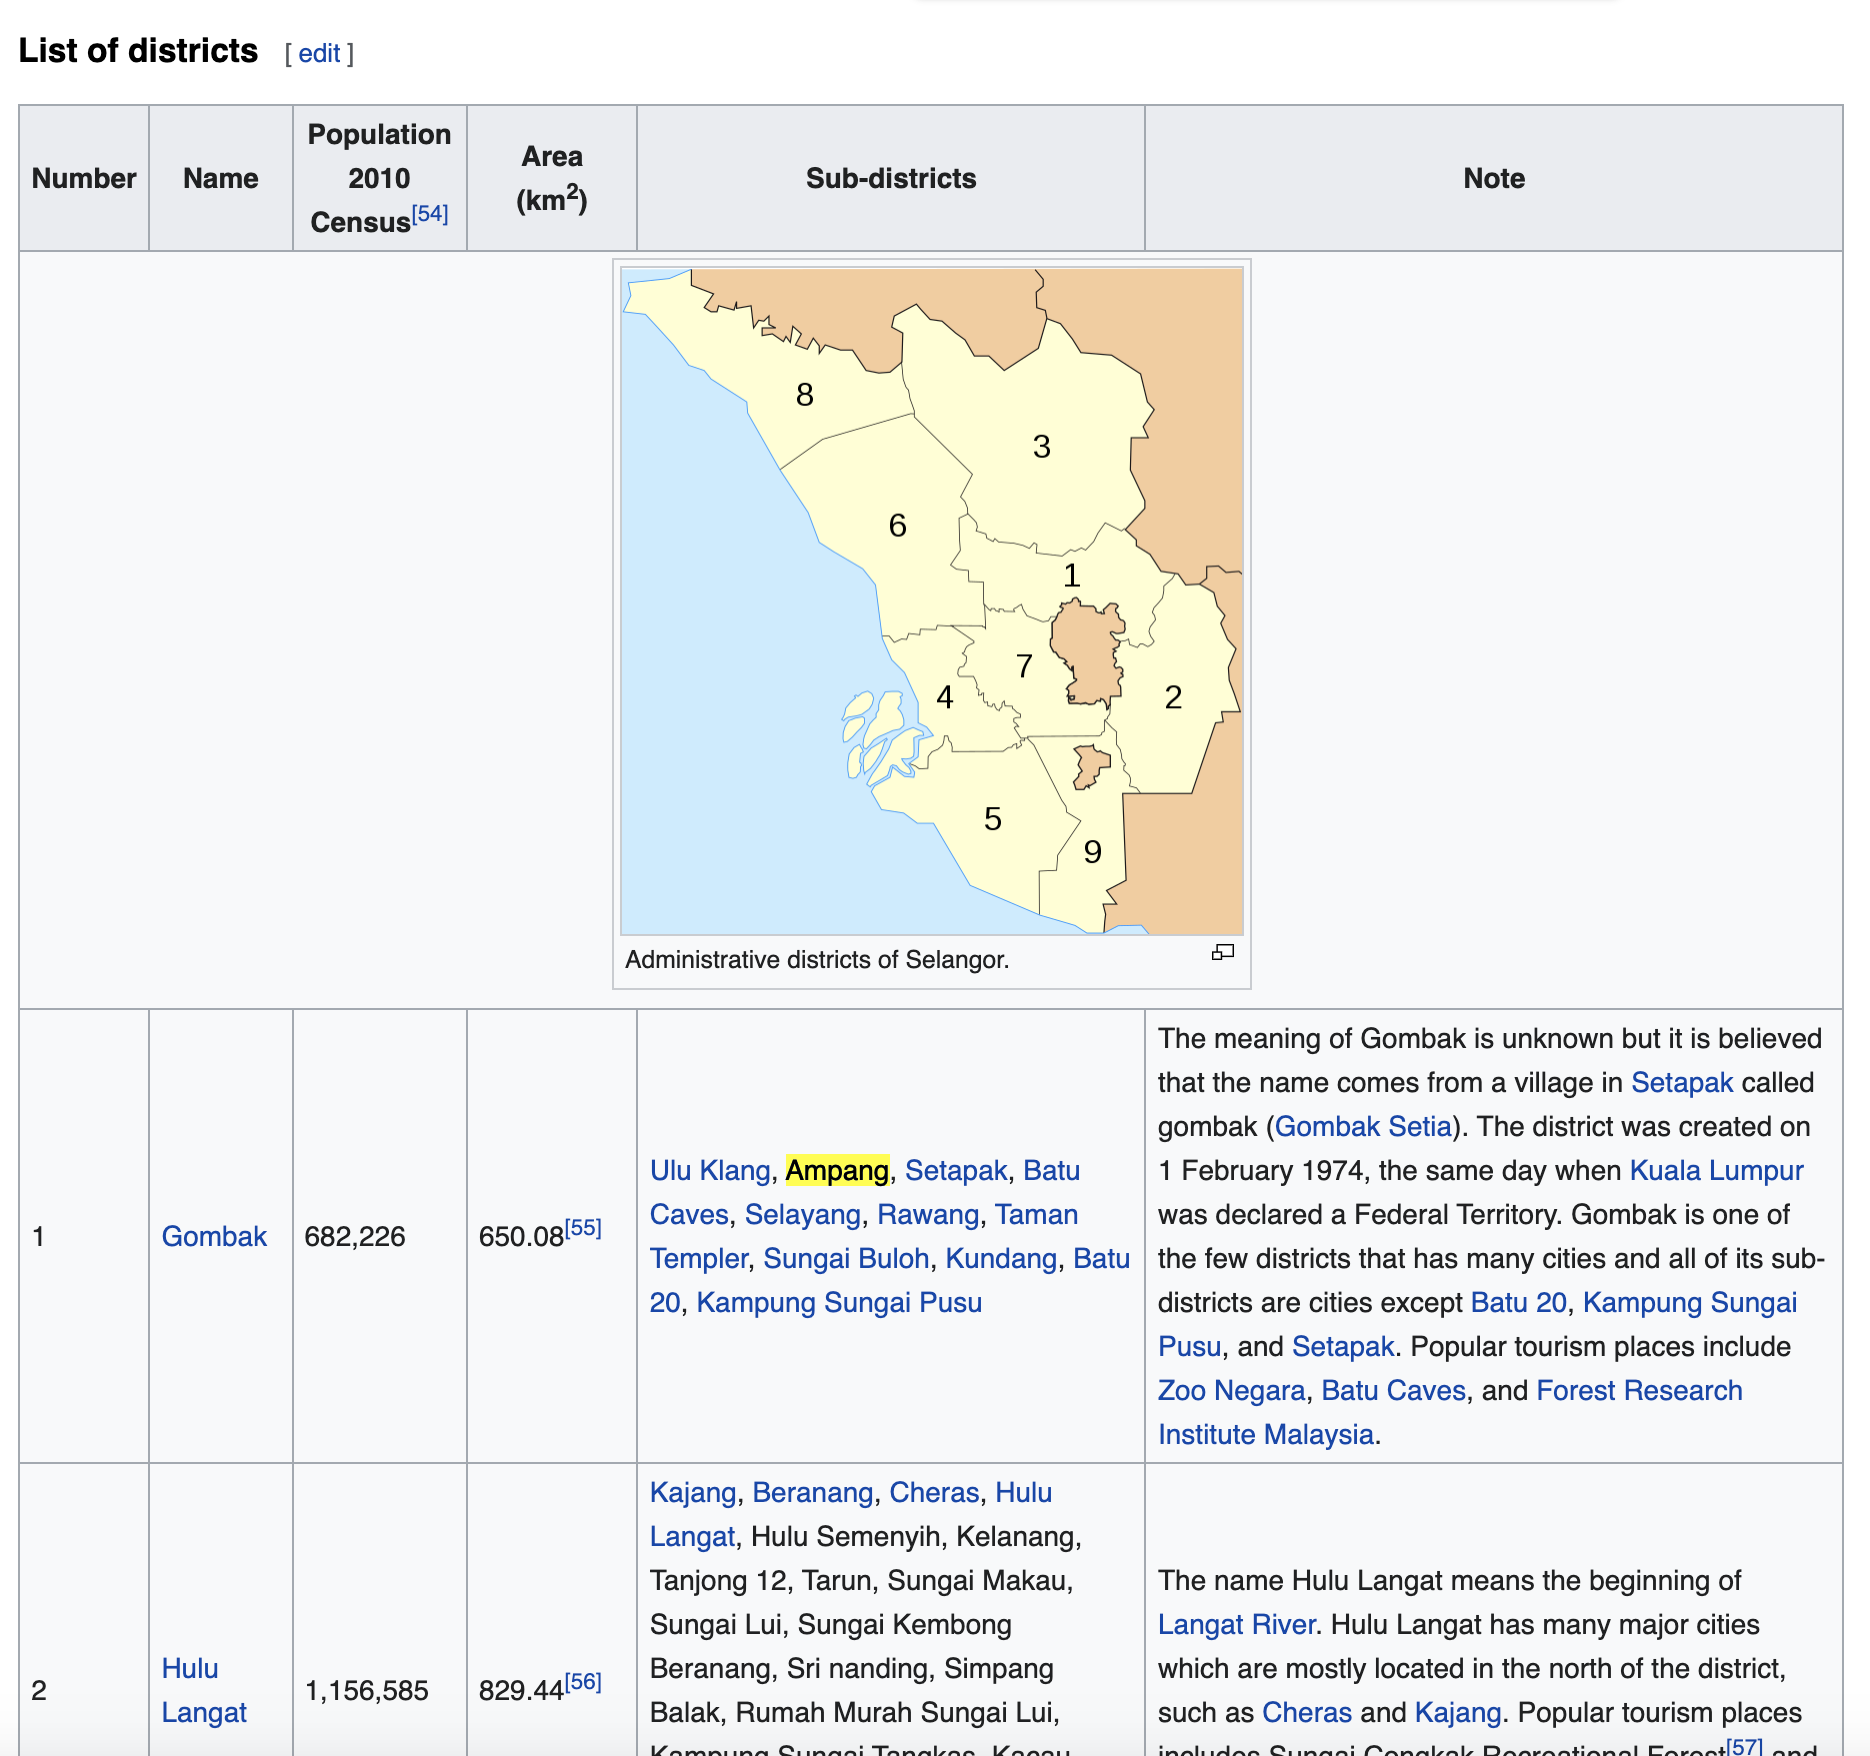

In [1]:
print('\n')

The table design above is such that the data in the table are stored under the sub-section `table` with class `wikitable`, with each column (`Number`, `Name`, `Sub-districts` etc) stored under `td`. I use these html sub-headings to scrape the data that I need using **BeautifulSoup**.

I only want to extract the `Name` and `Sub-districts` columns.

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# Scraping libraries
import json
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen

# Geocoding libraries
from geopy.geocoders import Nominatim

# Visualisation libraries
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import branca
import branca.colormap as cm

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
url = 'https://en.wikipedia.org/wiki/Selangor'
html = urlopen(url)
soup = BeautifulSoup(html, 'html.parser')

In [5]:
# Get sequential indexes that correspond to data that I want to collect from the Wiki table
dist_index = np.arange(2, 100, 6).tolist()
subdist_index = np.arange(5, 100, 6).tolist()

# Store results in empty lists
dists = []
subdists = []

for i in dist_index:
    try:
        dist = soup.find_all('table', class_='wikitable')[4].find_all('td')[i].text
        dists.append(dist)
    except:
        pass
        
for j in subdist_index:
    try:
        subdist = soup.find_all('table', class_='wikitable')[4].find_all('td')[j].text
        subdists.append(subdist)
    except:
        pass
        
# Append results into a fresh dataframe
locations = pd.DataFrame(list(zip(dists, subdists)), columns=['districts','subdistricts'])
locations

,districts,subdistricts
0,Gombak,"Ulu Klang, Ampang, Setapak, Batu Caves, Selaya..."
1,Hulu Langat,"Kajang, Beranang, Cheras, Hulu Langat, Hulu Se..."
2,Hulu Selangor,"Kuala Kubu Bharu, Sungai Chick, Ulu Yam, Ulu Y..."
3,Klang,"Klang, Kapar, Bukit Raja, Port Klang, Pandamar..."
4,Kuala Langat,"Bandar Saujana Putra, Jenjarom, Kanchong Darat..."
5,Kuala Selangor,"Api-api, Kuala Selangor, Puncak Alam, Bukit Me..."
6,Petaling,"Petaling Jaya, Subang Jaya, Shah Alam, Damansa..."
7,Sabak Bernam,"Sabak, Sungai Besar, Sekinchan."
8,Sepang,"Puchong, Bukit Puchong 2, 16 Sierra, Taman Put..."


In [6]:
print('\n')

Now that I have my districts and subdistricts, I need to clean it up by

- Separating every subdistrict into its own row; and
- Removing any duplicated subdistricts, or at least investigating further why we have similar subdistrict names.

I also manually add in cities of Kuala Lumpur to my dataframe. These are **Mont Kiara**, **Bukit Bintang**, **Sentul**, and **Bangsar**. 

After doing these clean-ups, I am left with a total of **126 unique subdistricts across 10 districts** for my Greater Kuala Lumpur locations dataset. See below for a sample of subdistricts.

In [7]:
locations['subdistricts'] = locations['subdistricts'].str.split(',')
locations = locations.explode('subdistricts')
locations.reset_index(drop=True, inplace=True)

# remove whitespaces, standardize texts etc
locations['subdistricts'] = locations['subdistricts'].str.replace('.', '').str.strip()

locations['subdistricts'].duplicated().sum()

2

In [8]:
locations[locations['subdistricts'].duplicated()]

,districts,subdistricts
110,Sepang,Puchong
120,Sepang,Beranang


In [9]:
locations[locations['subdistricts'] == 'Beranang']

,districts,subdistricts
12,Hulu Langat,Beranang
120,Sepang,Beranang


In [10]:
locations.drop(120, inplace=True)
locations.drop(110, inplace=True)
locations['subdistricts'].duplicated().sum()

0

In [11]:
kl_subdistricts = ['Mont Kiara', 'Bukit Bintang', 'Sentul',
                   'Bangsar', 'Sunway', 'Setia Alam']
kl_districts = ['Kuala Lumpur']*6

kl_locations = pd.DataFrame(list(zip(kl_districts, kl_subdistricts)), columns=['districts','subdistricts'])

locations = locations.append(kl_locations)
locations.reset_index(drop=True, inplace=True)

In [12]:
locations.sample(10)

,districts,subdistricts
104,Petaling,Merbau Sempak
111,Sepang,16 Sierra
53,Klang,Batu 4
57,Kuala Langat,Sijangkang
27,Hulu Langat,Kampung Pasir Batu 14 Semenyih
49,Klang,Telok Menegun
87,Kuala Selangor,Kg Baru Hulu Tiram Buruk
79,Kuala Selangor,Ujong Permatang
69,Kuala Langat,Jugra
109,Sabak Bernam,Sekinchan


---

<a id='geopy'></a>
## Geocode locations data using Geopy

In order to get the approximate coordinates of each subdistrict, I use the [Geopy library to make API requests to Nominatim](https://towardsdatascience.com/things-to-do-with-latitude-longitude-data-using-geopy-python-1d356ed1ae30), which is a geocoding tool used for OpenStreetMap, to get the coordinates of my subdistricts using the address format `subdistrict, district, Malaysia`.

Geopy was able to **successfully geocode 96 out of the total of 126 neighborhoods.** 24% of addresses failed to be geocoded. I will remove these neighborhoods from my dataframe. 

In [13]:
# add malaysia column to df
locations['country'] = 'Malaysia'
locations['address'] = locations['subdistricts'] + ', ' + locations['districts'] + ', ' + locations['country']
locations['latitude'] = ''
locations['longitude'] = ''

In [14]:
# Do a loop to geocode addresses
for i,j in tqdm(locations.iterrows()):
    try:
        locator = Nominatim(user_agent='myGeocoder')
        location = locator.geocode(j['address'])
        lat = location.latitude
        lng = location.longitude
        locations.loc[i, 'latitude'] = lat
        locations.loc[i, 'longitude'] = lng
    except:
        pass

126it [01:11,  1.75it/s]


In [15]:
locations = pd.read_csv('./data/locations.csv')
locations.sample(5)

,districts,subdistricts,country,address,latitude,longitude
19,Hulu Langat,Sungai Raya,Malaysia,"Sungai Raya, Hulu Langat, Malaysia",3.065522,101.778496
94,Kuala Lumpur,Bangsar,Malaysia,"Bangsar, Kuala Lumpur, Malaysia",3.130830,101.669440
13,Hulu Langat,Hulu Semenyih,Malaysia,"Hulu Semenyih, Hulu Langat, Malaysia",2.944485,101.876028
28,Hulu Selangor,Peretak,Malaysia,"Peretak, Hulu Selangor, Malaysia",3.548872,101.679012
90,Sepang,Salak Tinggi,Malaysia,"Salak Tinggi, Sepang, Malaysia",2.825446,101.713120


In [16]:
locations_folium = locations[['subdistricts','latitude','longitude']]
locations_folium = locations_folium[locations_folium['latitude']!='']

In [17]:
print('\n')

Let's also plot a **Folium map** using these newly geocoded neighborhoods. We can see that they are all within the Greater Kuala Lumpur region.

In [18]:
# Initialise Folium map
map_f = folium.Map()

# Add pins to map iteratively
for i, j in locations_folium.iterrows():
    folium.Marker([j['latitude'], j['longitude']], 
                  popup=j['subdistricts'],
                  radius=6).add_to(map_f)

# Determine zoom scope/ map frame using SW and NE coordinates
sw = locations_folium[['latitude','longitude']].min().values.tolist()
ne = locations_folium[['latitude','longitude']].max().values.tolist()

map_f.fit_bounds([sw, ne])
map_f

In [19]:
print('\n')

**<u>Delineate geographical bounds of neighborhoods</u>**

Based on the visualization above, some of the pins are located very close to each other, such as Damansara and Kayu Ara, and Sri Batu and Sri Nanding. 

I want my neighborhoods to have a distance threshold that differentiates one from another, so I identify neighborhoods that are located within 3km from another, and remove one of them from my dataframe.

To do so, a function was defined to calculate the distance between all of my coordinates. The idea behind the function is that (1) it goes through every row of neighborhood in my locations dataframe, (2) calculates all distances between the neighborhood in question and all other neighborhood, (3) picks the shortest distance and its corresponding nearest neighborhood for the neighborhood in question, and finally (4) appends these information in the dataframe. The function is applied in a loop so that it goes through all neighborhoods of the dataframe on a row by row basis.

In [20]:
# convert coordinates from object to float
locations['latitude'] = locations['latitude'].astype(float)
locations['longitude'] = locations['longitude'].astype(float)

In [21]:
# Define function to calculate distance between each coordinate
def calculate_distance(df1, df2):
    global locations_final
    
    # From df2, remove rows that df1 selected
    subdist = df1['subdistricts'].values.tolist()[0]
    df2 = df2[df2['subdistricts']!=subdist].reset_index(drop=True)
    
    # Convert latitude and longitude pairs into numpy array
    coord1 = df1[['latitude', 'longitude']].to_numpy()
    coord2 = df2[['latitude', 'longitude']].to_numpy()

    # Convert coordinates to radians
    rad1, rad2 = np.radians(coord1), np.radians(coord2)

    # Get the differentiations between the coordinates
    lat = rad2[:,0] - rad1[:,0,None]
    lng = rad2[:,1] - rad1[:,1,None]

    # Compute the differentiation results in the Haversine function
    add0 = np.cos(rad1[:,0,None]) * np.cos(rad2[:,0]) * np.sin(lng*0.5)**2
    d = np.sin(lat*0.5)**2 + add0

    # Calculate nearest distance
    AVG_EARTH_RADIUS = 6.3781*1e6
    haversine_distances = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    
    # Get nearest subdistrict and note it down into df, as well as the distance in meter
    df1['nearest_subdist'] = haversine_distances.argmin(1)
    df1['min_distance_m'] = haversine_distances.min(1)
    df1['min_distance_m'] = round(df1['min_distance_m'], 2)
    
    # Get the subdistrict name from its index
    df2['index'] = range(0, len(df2))
    df2_map = df2.set_index('index')[['subdistricts']].T.to_dict('records')[0]
    df1['nearest_subdist'] = df1['nearest_subdist'].map(df2_map)
    
    # Append the shortest distance in meter and its corresponding
    # nearest neighborhood of each neighborhood of the dataframe,
    # row by row
    locations_final = locations_final.append(df1)

In [22]:
locations_final = pd.DataFrame(columns=locations.columns)

# Apply function
for i,j in locations.iterrows():
    locations_row = pd.DataFrame(locations.loc[i, :]).transpose()
    locations_row['latitude'] = locations_row['latitude'].astype(float)
    locations_row['longitude'] = locations_row['longitude'].astype(float)
    calculate_distance(locations_row, locations)

In [23]:
print('\n')

The dataset below shows the results after applying the function that calculates distances between all neighborhoods and subsequently selecting the shortest distance. 

I will remove neighborhoods that are located close to each other (at a distance threshold of 3km).

In [24]:
locations_final.sample(5)

,districts,subdistricts,country,address,latitude,longitude,nearest_subdist,min_distance_m
57,Kuala Selangor,Ijok,Malaysia,"Ijok, Kuala Selangor, Malaysia",3.313918,101.416623,Puncak Alam,7244.75
31,Hulu Selangor,Bukit Sentosa,Malaysia,"Bukit Sentosa, Hulu Selangor, Malaysia",3.398798,101.567658,Bukit Beruntung,3092.08
36,Klang,Pandamaran,Malaysia,"Pandamaran, Klang, Malaysia",3.009209,101.416381,Port Klang,2305.34
7,Gombak,Kundang,Malaysia,"Kundang, Gombak, Malaysia",3.283333,101.516670,Puncak Alam,5774.34
3,Gombak,Batu Caves,Malaysia,"Batu Caves, Gombak, Malaysia",3.237451,101.681226,Batu 20,354.22


In [25]:
# look for distances that are less than 3k
locations_final[locations_final['min_distance_m'] <= 3000]

short_distance = locations_final[locations_final['min_distance_m'] <= 3000]
short_distance_remove_list = short_distance[['subdistricts','nearest_subdist']].values.tolist()

# remove duplicates from short_distance_remove
dup = []

for i in short_distance_remove_list:
    dup.append(', '.join(np.sort(i)))
    
short_distance.reset_index(drop=True, inplace=True)
short_distance['dup'] = pd.Series(dup)

short_distance.drop_duplicates('dup', keep='first', inplace=True)

# combine above with original df
locations_final = locations_final[locations_final['min_distance_m'] > 3000]
locations_final = pd.concat([locations_final, short_distance])
locations_final.reset_index(drop=True, inplace=True)

In [26]:
locations_final_folium = locations_final[['subdistricts','latitude','longitude']]

map_f2 = folium.Map()

tooltip = 'Click for subdistrict name'

for i, j in locations_final_folium.iterrows():
    folium.Marker([j['latitude'], 
                   j['longitude']], 
                  popup=j['subdistricts'],
                  tooltip=tooltip).add_to(map_f2)
    
sw = locations_final_folium[['latitude','longitude']].min().values.tolist()
ne = locations_final_folium[['latitude','longitude']].max().values.tolist()

map_f2.fit_bounds([sw, ne])
map_f2

---

<a id='foursquare'></a>
## Get restaurants of different cuisines from Foursquare API

Next, I use [Foursquare API](https://developer.foursquare.com) to extract restaurants of different cuisines across my neighborhoods. The idea is that I would make API requests to extract restaurants that are within 3km of my coordinates, for each cuisine. I will also specify that only a limit of 100 restaurants may be queried for each API request. These are parameters that I would set in my query url.

Foursquare has data for a variety of different [venue categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/), such as **Arts & Entertainment**, **College & University**, **Event**, and our target, **Food**. Housed within these venue categories, are further 'sub-venues' such as the type of arts & entertainment (aquarium, art gallery, casino), or the type of food places (Afghan restaurant, African restaurant, cafe, BBQ joint) etc. So, we see that my data of interest lie within **Food**, and depending on which restaurant cuisine I am interested to collect data from, I specify it in my query.

Foursquare has at least 50 different types of food places. However, I will only select 30 different cuisines which I add to my dictionary key-value pairs.

Most of my cuisines are of Asian origins, such as Malay, Chinese, Indian (Malaysia's local population), as well as from neighboring South-East Asian countries such as Burmese, Cambodian, Thailand, and more. Meanwhile, only a handful of international cuisines such as American, English, French, German, and a few others were selected.

In [27]:
VERSION = '20210831'
CLIENT_ID1 = 'E25VYC25XDBNPZR4MAAFCPO2SKBPACHL5JAZSG4P4JJQRHNT'
CLIENT_SECRET1 = 'ROZNTDEX23UJN1EZLJA04IT4VWSJHLGIEBZCUXZW34O2UURI'

# CLIENT_ID1 = '4TTHY42GDGM4C1IPYE0AOMWNXSPKDKZIUB1NYEOEJWSHUCTR'
# CLIENT_SECRET1 = 'A5FYROVMAYQ3EKFPH55XVP4OGDNXQCFTGMH11PZXXPSGCE4E'

CLIENT_ID2 = 'C4T31HYLQFNL20G4L3DDJ31AA2EYREKHDRRFT2WISQVBJQDT'
CLIENT_SECRET2 = 'LGO1OYNWXDGBPHBNWOWZZXCSS1RGBT0NWD0N2FSQ5R5UNQXY'

CLIENT_ID3 = 'KQTFTBZI1EME3LJKLHJO0YW1NOIJRFQKJKOMZGONAMLM5XHI'
CLIENT_SECRET3 = '20POEGOZXC3XZFGLZA25P0XJFCQNB3FTAVSUWRS3H2WASH4W'

In [28]:
# Get all food cuisines in a dict
cuisines_map = {
    'Afghan': '503288ae91d4c4b30a586d67', 
    'African': '4bf58dd8d48988d1c8941735', 
    'American': '4bf58dd8d48988d14e941735', 
    'Burmese': '56aa371be4b08b9a8d573568', 
    'Cambodian': '52e81612bcbc57f1066b7a03', 
    'Chinese': '4bf58dd8d48988d145941735', 
    'Filipino': '4eb1bd1c3b7b55596b4a748f',
    'Indonesian': '4deefc054765f83613cdba6f', 
    'Japanese': '4bf58dd8d48988d111941735', 
    'Korean': '4bf58dd8d48988d113941735', 
    'Malay': '4bf58dd8d48988d156941735', 
    'Mongolian': '4eb1d5724b900d56c88a45fe', 
    'Thai': '4bf58dd8d48988d149941735', 
    'Vietnamese': '4bf58dd8d48988d14a941735', 
    'Bangladeshi': '5e179ee74ae8e90006e9a746', 
    'Caribbean': '4bf58dd8d48988d144941735',
    'English': '52e81612bcbc57f1066b7a05', 
    'French': '4bf58dd8d48988d10c941735', 
    'German': '4bf58dd8d48988d10d941735', 
    'Indian': '4bf58dd8d48988d10f941735', 
    'Italian': '4bf58dd8d48988d110941735',  
    'Mediterranean': '4bf58dd8d48988d1c0941735', 
    'Mexican': '4bf58dd8d48988d1c1941735',
    'Pakistani': '52e81612bcbc57f1066b79f8', 
    'Portuguese': '4def73e84765ae376e57713a', 
    'Russian': '5293a7563cf9994f4e043a44',
    'Spanish': '4bf58dd8d48988d150941735', 
    'Sri Lankan': '5413605de4b0ae91d18581a9', 
    'Middle Eastern': '4bf58dd8d48988d115941735',
    'South American': '4bf58dd8d48988d1be941735'
}

cuisines = list(zip(cuisines_map.keys(), cuisines_map.values()))

In [29]:
print('\n')

Besides extracting the mere numbers of restaurants for each cuisine for every neighborhood, I will also extract their names and coordinates.

Below is the code I used to make my API requests.

In [ ]:
# Define parameters
radius = 3000
LIMIT = 100

# Initialise empty lists to store results from each query
restaurant_name = []
restaurant_cuisine = []
restaurant_lat = []
restaurant_long = []
restaurant_subdistrict = []

# To keep track of the number of queries made
iteration = 0

# Do a loop by starting off the queries by each cuisine
for a in cuisines:
    cuisine = a[0]
    cuisine_code = a[1]
    
    # Create new columns in the dataframe for each cuisine to store number
    # of restaurants
    locations_final[cuisine] = ''
    
    # Do another loop to query the restaurants for each cuisine on a 
    # neighborhood to neighborhood bases
    for i,j in locations_final.iterrows():
        iteration += 1 
        rest_subdistrict = j['subdistricts']
        latitude = j['latitude']
        longitude = j['longitude']
        # Define url and input parameters
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
              CLIENT_ID,
              CLIENT_SECRET,
              VERSION,
              latitude,
              longitude, 
              radius,
              LIMIT,
              cuisine_code)

        time.sleep(0.5)
        
        # Extract nested results
        results = requests.get(url).json()['response']['groups'][0]['items']
        rest_number = len(results)
        print(f"ITERATION {iteration}")

        # Insert number of restaurants ('rest_number') into dataframe
        locations_final.loc[i, cuisine] = rest_number

        # Insert other data we want such as restaurant name, food type, 
        # and coordinates into a new dataframe
        for b in range(0, rest_number):
            rest_name = results[b]['venue']['name']
            rest_cuisine = results[b]['venue']['categories'][0]['name']
            rest_lat = results[b]['venue']['location']['lat']
            rest_long = results[b]['venue']['location']['lng']
            print(f"{b}: {rest_name}")

            restaurant_name.append(rest_name)
            restaurant_cuisine.append(rest_cuisine)
            restaurant_lat.append(rest_lat)
            restaurant_long.append(rest_long)
            restaurant_subdistrict.append(rest_subdistrict)

In [30]:
print('\n')

After performing the queries, I get a total of **18,294 restaurants of 30 different cuisines across 78 neighborhoods in Greater Kuala Lumpur**. 

The dataframe below shows us values representing the number of restaurants for each cuisine (see columns).

As a whole, Malay restaurants are the highest in number, followed by Chinese and Indian restaurants. Among the remaining top 7 restaurant cuisines are: Thai, Japanese, Indonesian, Korean, Middle Eastern, and Italian. 

On the other hand, Burmese, Sri Lankan, Russian, Cambodian, and Bangladeshi seem to make up the lowest number of restaurant cuisines.

In [31]:
count_df = pd.read_csv('./data/locations_cuisines_count_final.csv')
count_df.drop(['dup'], axis=1).sample(5)

,districts,subdistricts,country,address,latitude,longitude,nearest_subdist,min_distance_m,Afghan,African,...,Italian,Mediterranean,Mexican,Pakistani,Portuguese,Russian,Spanish,Sri Lankan,Middle Eastern,South American
49,Kuala Lumpur,Mont Kiara,Malaysia,"Mont Kiara, Kuala Lumpur, Malaysia",3.169999,101.652147,Sunway,4490.54,3,3,...,35,10,11,2,5,1,10,3,14,4
37,Petaling,Shah Alam,Malaysia,"Shah Alam, Petaling, Malaysia",3.073364,101.519515,Batu Tiga,4237.59,13,5,...,4,2,4,4,2,0,2,0,11,4
14,Hulu Selangor,Sungai Choh,Malaysia,"Sungai Choh, Hulu Selangor, Malaysia",3.346753,101.585029,Serendah,3156.13,2,1,...,1,0,0,0,0,0,0,0,1,1
53,Gombak,Batu Caves,Malaysia,"Batu Caves, Gombak, Malaysia",3.237451,101.681226,Batu 20,354.22,7,4,...,2,1,4,3,2,0,1,0,8,4
15,Hulu Selangor,Bukit Beruntung,Malaysia,"Bukit Beruntung, Hulu Selangor, Malaysia",3.424334,101.556708,Bukit Sentosa,3092.08,1,0,...,0,1,0,0,0,1,1,0,3,1


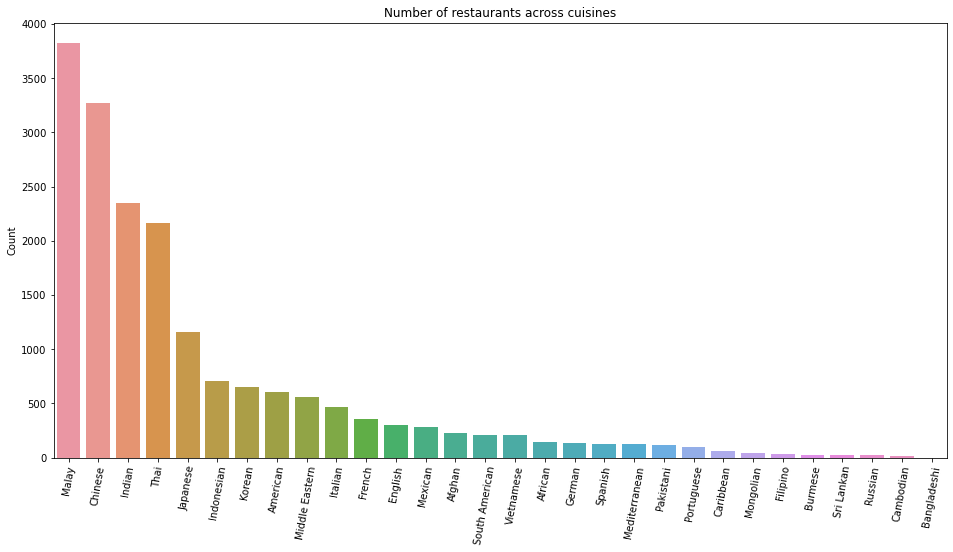

In [32]:
barchart1 = count_df[cuisines_map.keys()].sum().to_frame().rename(columns={0:'sum'})
barchart1.reset_index(inplace=True)
barchart1 = barchart1.sort_values(by='sum', ascending=False)

plt.figure(figsize=(16,8))
sns.barplot(x=barchart1['index'], 
            y=barchart1['sum'])
plt.title('Number of restaurants across cuisines')
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(rotation=80);

In [33]:
print('\n')

**<u>Observing inaccurate tagging of restaurants to venue categories</u>**

We also have another set of results that contain the restaurant names, food types, and restaurant coordinates. Unlike the 1st set of results, we get to do a quick check on whether or not the types of restaurants were categorized correctly in Foursquare.

In the sample below, we see 10 different restaurants and their tagged venue categories. By a simple eye-balling of the restaurant names, it looks like they were tagged correctly.

However, we also see that there are restaurants that were tagged as non-restaurant or non-food venues. See below for some of these examples.

In [34]:
names_df = pd.read_csv('./data/locations_cuisines_names_final.csv')
names_df.rename(columns={'cuisine':'venue'}, inplace=True)
names_df[names_df['venue'].str.contains('restau', case=False)].sample(10, random_state=1)

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
15707,Damansara,RK Restaurant,Indian Restaurant,3.152039,101.594217
17241,Sentul,Restoran Pak Punjab,Pakistani Restaurant,3.169809,101.695146
14442,Petaling Jaya,Restoran Kenchana Warisan,Indian Restaurant,3.092033,101.620764
16141,Bukit Bintang,Fatimah Food Corner,Indian Restaurant,3.150752,101.708636
8145,Shah Alam,Restoran Mega Sup Utara,Malay Restaurant,3.055561,101.530159
876,Bukit Bintang,Gerai Payung Selera Kampung,American Restaurant,3.161414,101.698463
2614,Mont Kiara,Ah Yip Herbal Soup 阿業靚湯,Chinese Restaurant,3.170723,101.667282
3788,Puchong,Mr.Pot Hotpot,Chinese Restaurant,3.025238,101.616455
8714,Cyberjaya,Sepiring,Malay Restaurant,2.922315,101.651436
9942,Damansara,Brother John Kopitiam,Malay Restaurant,3.150711,101.593880


In [35]:
print('\n')

**<u>Example 1:</u>**

Music venues

In [36]:
names_df[names_df['venue'].str.contains('music', case=False)]

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
6748,Bukit Bintang,Pulse Ultra Club,Music Venue,3.147828,101.712538


In [37]:
print('\n')

**<u>Example 2:</u>**

Cafeterias

In [38]:
names_df[names_df['venue'].str.contains('cafe', case=False)]

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
840,Sungai Besi,Kantin Kolam Renang (UPNM),College Cafeteria,3.049157,101.725074
4474,Subang Jaya,Cafeteria,College Cafeteria,3.064110,101.600533
4574,Cyberjaya,Techno Cafe,Cafeteria,2.927431,101.662723
4822,Puchong Jaya,Cafeteria,College Cafeteria,3.064110,101.600533
10219,Puchong Jaya,Cafeteria,College Cafeteria,3.064110,101.600533


In [39]:
print('\n')

**<u>Example 3:</u>**

Grocery stores, shoe stores..

In [40]:
names_df[names_df['venue'].str.contains('store', case=False)]

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
14052,Kajang,7-Eleven@Kajang Prima,Grocery Store,2.983307,101.815366
14617,Bandar Sri Damansara,Jaya Grocer Sierramas,Grocery Store,3.202972,101.589149
17437,Ulu Klang,Tropicana Life,Clothing Store,3.178227,101.749273
18165,Glenmarie,Samba @ Paradigm Mall,Shoe Store,3.105005,101.596040
18177,Cyberjaya,Jabatan Pertanian,Thrift / Vintage Store,2.915300,101.683300
18190,Ulu Klang,786 restoran masha,Liquor Store,3.144613,101.767891


In [41]:
print('\n')

**<u>Example 4:</u>**

Coffee shops, dessert shops..

In [42]:
names_df[names_df['venue'].str.contains('shop', case=False)]

,subdistrict,restaurant_name,venue,restaurant_latitude,restaurant_longitude
261,Subang Jaya,Garage 51,Coffee Shop,3.066874,101.603199
297,Bangsar,The Manhattan Fish Market,Fish & Chips Shop,3.116283,101.676483
333,Puchong Jaya,Garage 51,Coffee Shop,3.066874,101.603199
359,Bukit Bintang,dal.komm COFFEE,Coffee Shop,3.158002,101.712327
372,Sentul,dal.komm COFFEE,Coffee Shop,3.158002,101.712327
...,...,...,...,...,...
17421,Mont Kiara,瓜拉雪蘭莪潮洲海鮮飯店,Food & Drink Shop,3.188538,101.641847
17460,Damansara,Fat Olive,Coffee Shop,3.117199,101.594729
17477,Bukit Bintang,Feeka Coffee Roasters,Coffee Shop,3.148780,101.708496
18101,Kampung Sungai Tangkas,Pak abu cendol n bistro,Dessert Shop,2.973550,101.791080


In [43]:
print('\n')

So, we see restaurants that had incorrectly tagged venue categories. This means, **the number of restaurants that I had gotten from Foursquare across all cuisines are somewhat overestimated**. These are food places that do not belong to restaurants, which is what my analysis is mostly concerned about (the diversity of restaurant cuisines).

Ultimately, I found that **out of 18,294 food places that were extracted, 92% are restaurants (16,762)**. The rest are either non-restaurant food places such as coffee shops, cafes, or venues that are unrelated to food such as colleges, sport shops. 

Nevertheless, since a majority of restaurants were tagged correctly as restaurants, I will proceed with my analysis without the removal of the incorrectly tagged restaurants. I also bear in mind that there may be restaurants with incorrectly tagged *cuisines*. 

For example, my dataset has a restaurant named Gerai Payung Selera Kampung that was tagged as an American restaurant...which is clearly...wrong.

---

<a id='top_cuisines'></a>
## Visualise top restaurant cuisines of neighborhoods

Now, let's look at what the top 3 restaurant cuisines are for each neighborhood. Let's also take it a step further and group neighborhoods based on the unique combinations of their top 3 restaurant cuisines. 

To do so, I calculate the proportion of restaurant cuisines and select the top 3 for each neighborhood. This gets us the following results.

In [44]:
normalized_count_df = count_df.copy()
normalized_count_df.drop(['districts','country','address','latitude','longitude',
                           'nearest_subdist','min_distance_m','dup'], axis=1, inplace=True)
normalized_count_df.set_index('subdistricts', inplace=True)
normalized_count_df = normalized_count_df.div(normalized_count_df.sum(axis=1), axis=0)*100
print("Proportion of restaurant cuisines for each neighborhood:")
normalized_count_df.sample(5, random_state=1)

Proportion of restaurant cuisines for each neighborhood:


,Afghan,African,American,Burmese,Cambodian,Chinese,Filipino,Indonesian,Japanese,Korean,...,Italian,Mediterranean,Mexican,Pakistani,Portuguese,Russian,Spanish,Sri Lankan,Middle Eastern,South American
subdistricts,,,,,,,,,,,,,,,,,,,,,
Pasir Penambang,4.597701,1.149425,4.597701,1.149425,0.0,16.091954,0.000000,3.448276,3.448276,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.448276,2.298851
Sentul,2.889447,1.381910,4.522613,0.000000,0.0,12.562814,0.251256,9.045226,8.417085,2.638191,...,3.643216,1.005025,1.381910,1.633166,0.628141,0.376884,0.502513,0.0,5.527638,0.502513
Sungai Besar,0.000000,0.000000,0.000000,0.000000,0.0,5.357143,0.000000,1.785714,3.571429,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.785714,0.0,3.571429,0.000000
Api-api,0.000000,0.000000,10.000000,0.000000,0.0,30.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Bandar Saujana Putra,0.000000,0.000000,1.639344,0.000000,0.0,13.114754,0.000000,3.278689,3.278689,0.000000,...,0.000000,0.000000,1.639344,0.000000,0.000000,0.000000,0.000000,0.0,3.278689,1.639344


In [45]:
subdistricts_output = []
topcuisines_output = []
percents_output = []

subdistricts_output_list = []
topcuisines_output_list = []
percents_output_list = []

for i,j in normalized_count_df.iterrows():
    subdistricts = i
    subdistricts_output.extend([subdistricts]*3)
    subdistricts_output_list.append(subdistricts)
    
    topcuisines = normalized_count_df.loc[i,:].sort_values(ascending=False).head(3).to_frame().reset_index()['index'].tolist()
    topcuisines_output.extend(topcuisines)
    topcuisines_output_list.append(topcuisines)
    
    percents = normalized_count_df.loc[i,:].sort_values(ascending=False).head(3).to_frame().reset_index()[i].tolist()
    percents_output.extend(percents)
    percents_output_list.append(percents_output)
    
top3_cuisines_long = pd.DataFrame(list(zip(subdistricts_output, topcuisines_output, percents_output)),
                          columns=['subdistrict', 'top_cuisines', '%'])
print("Top 3 restaurant cuisines for each neighborhood:")
top3_cuisines_long

Top 3 restaurant cuisines for each neighborhood:


,subdistrict,top_cuisines,%
0,Selayang,Malay,31.746032
1,Selayang,Chinese,29.523810
2,Selayang,Indian,12.063492
3,Rawang,Chinese,37.899543
4,Rawang,Malay,26.940639
...,...,...,...
229,Bukit Bintang,Indonesian,7.230658
230,Bukit Bintang,Indian,7.230658
231,Sentul,Malay,12.562814
232,Sentul,Indian,12.562814


In [46]:
# create a new df containing the top 3 cuisines for each subdistrict using the lists above
top3_cuisines_wide = pd.DataFrame(topcuisines_output_list, columns=['1st','2nd','3rd'])
top3_cuisines_wide['subdistrict'] = subdistricts_output_list
top3_cuisines_wide['combine'] = top3_cuisines_wide['1st'] + ', ' + top3_cuisines_wide['2nd'] + ', ' + top3_cuisines_wide['3rd']
print("Unique combinations of top 3 restaurant cuisines for each neigborhood:")
top3_cuisines_wide.rename(columns={'combine':'top_cuisines_combined'})

Unique combinations of top 3 restaurant cuisines for each neigborhood:


,1st,2nd,3rd,subdistrict,top_cuisines_combined
0,Malay,Chinese,Indian,Selayang,"Malay, Chinese, Indian"
1,Chinese,Malay,Indian,Rawang,"Chinese, Malay, Indian"
2,Pakistani,Malay,Indian,Taman Templer,"Pakistani, Malay, Indian"
3,Malay,Chinese,Thai,Kundang,"Malay, Chinese, Thai"
4,Chinese,Malay,Indian,Kajang,"Chinese, Malay, Indian"
...,...,...,...,...,...
73,Malay,Thai,Indian,16 Sierra,"Malay, Thai, Indian"
74,Chinese,Malay,Indian,Taman Putra Prima,"Chinese, Malay, Indian"
75,Malay,Chinese,Indian,Taman Mas,"Malay, Chinese, Indian"
76,Malay,Indonesian,Indian,Bukit Bintang,"Malay, Indonesian, Indian"


In [47]:
print('\n')

**<u>Visualizations</u>**

The grouped bar charts below show us neighborhoods of similar top 3 cuisine combinations. The darker shaded bar charts are of the local cuisines (Malay, Chinese, Indian), while the ligher ones are foreign cuisines. From the visualisations below, we see that:

- Local cuisines dominate the top 3 cuisines across most neighourhoods. In particular, we see a differentiation between Malay-cuisine dominated neighborhoods (first plot) and Chinese-cuisine dominated neighborhoods (second plot). Kuala Sungai Buloh seems to be the only neighborhood with Indian the #1 top cuisine. 

- Across all 24 subdistricts of our analysis, while there are various combinations of top 3 cuisines, all neighborhoods have at least one of the local cuisines (Malay, Chinese, Indian) as their top 3.

- A handful of neigborhoods (see last few plots) have relatively low proportions (< 20%) of their respective top 3 cuisines, which indicates a higher diversity of restaurant cuisines in these areas. 

In [48]:
# format % to whole numbers
top3_cuisines_long['%'] = round(top3_cuisines_long['%'],0).astype(int)
unique_top3 = top3_cuisines_wide['combine'].unique().tolist()

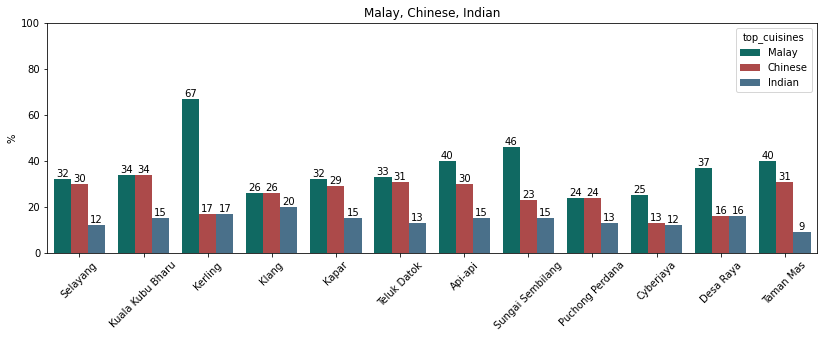

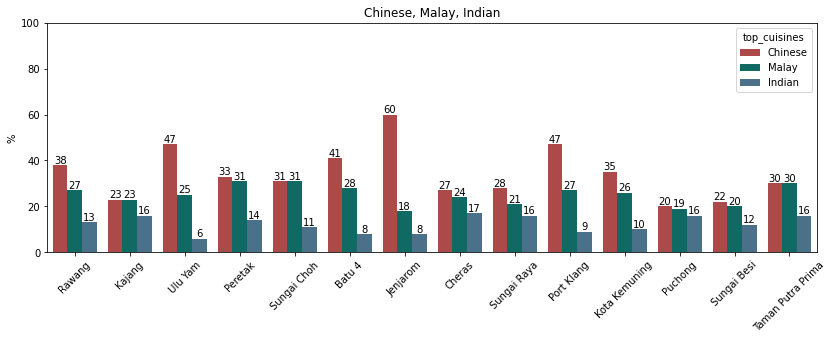

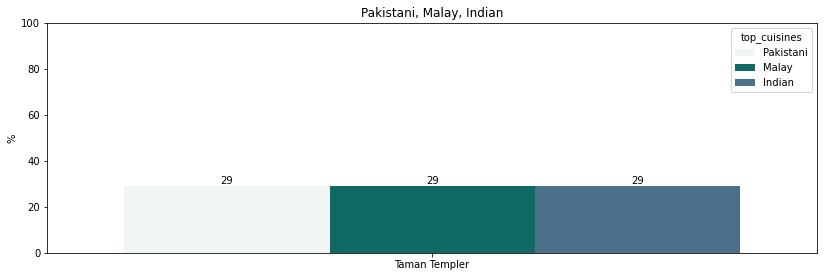

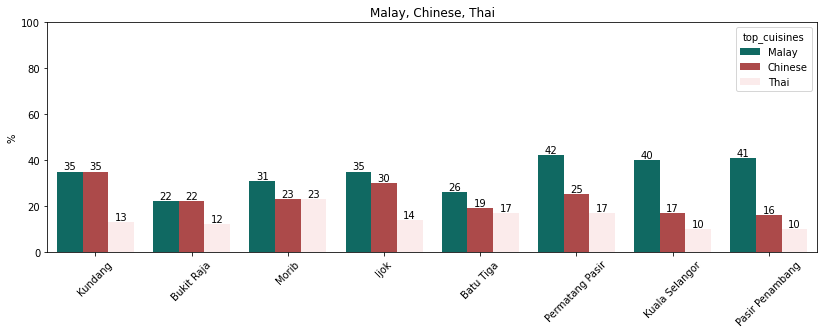

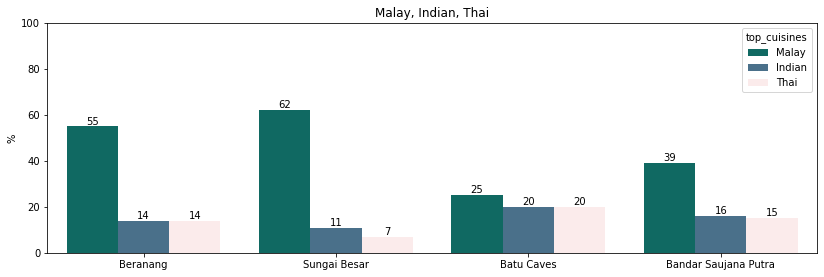

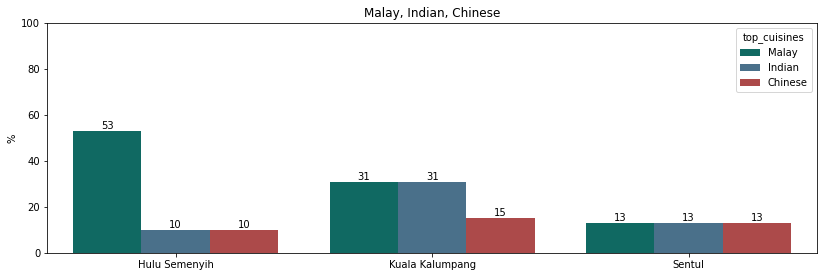

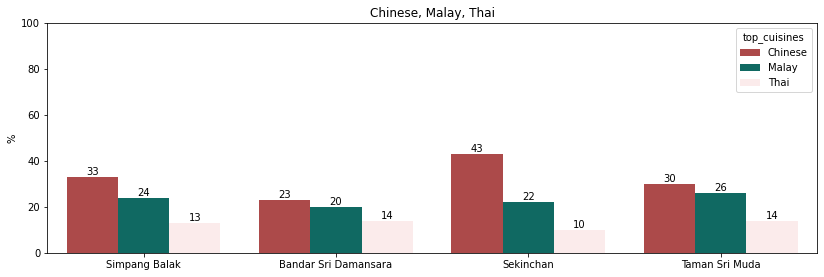

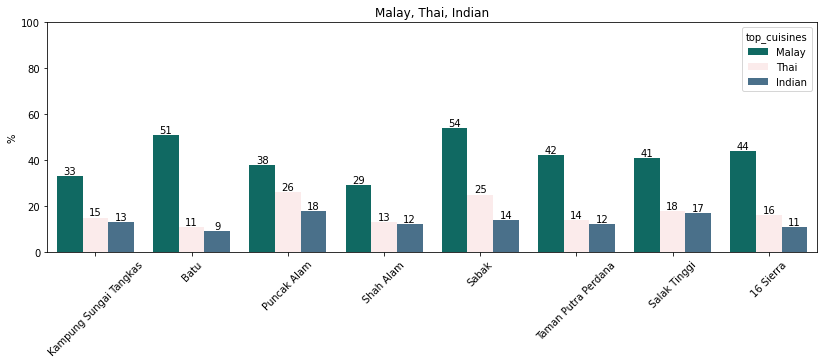

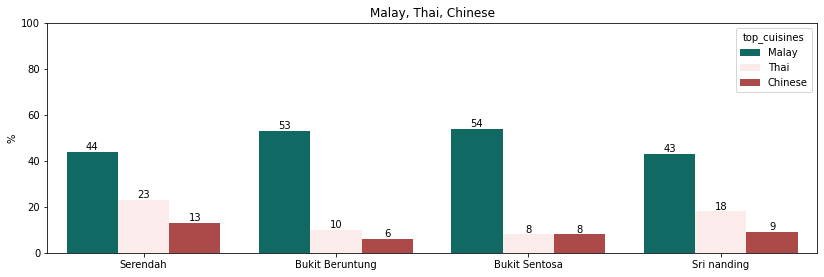

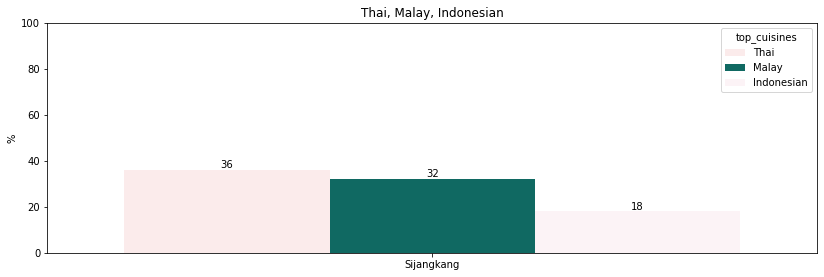

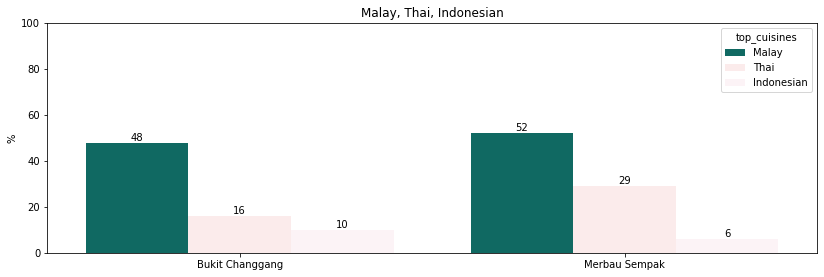

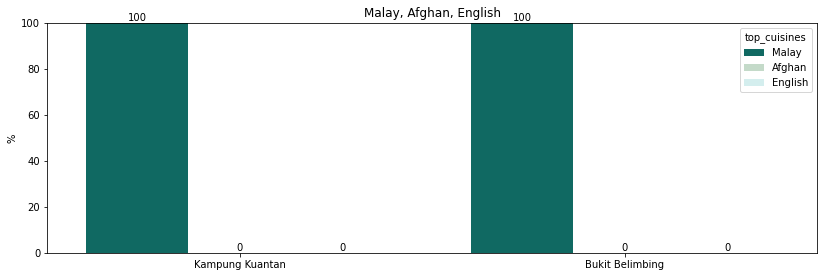

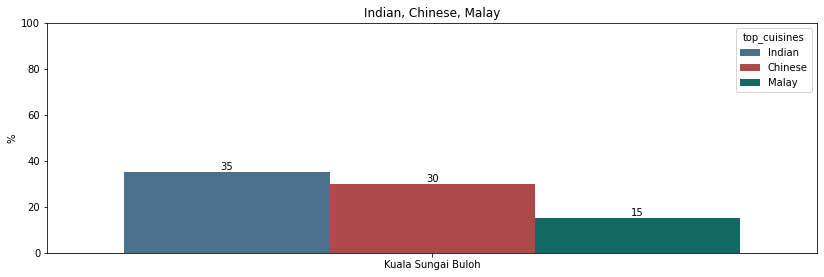

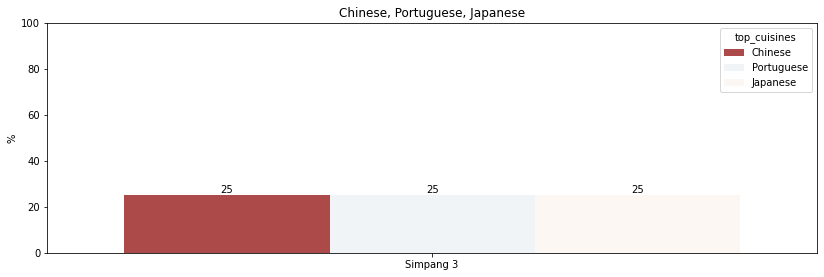

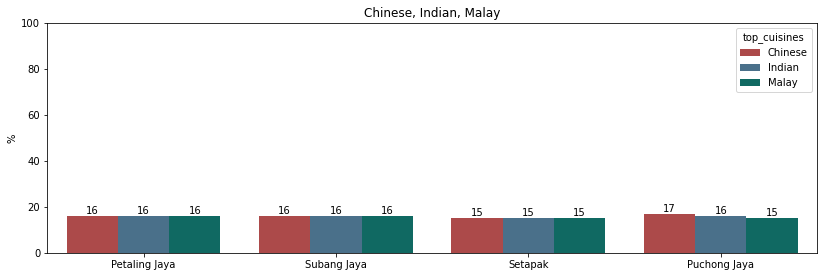

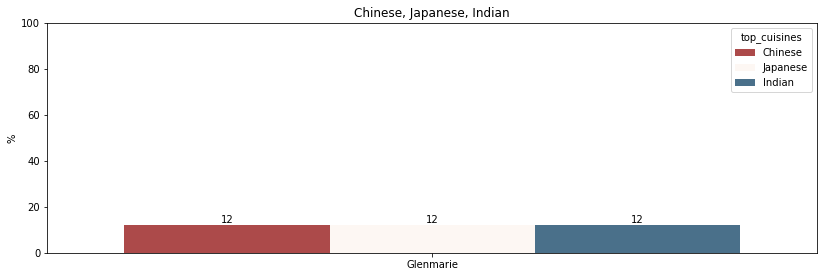

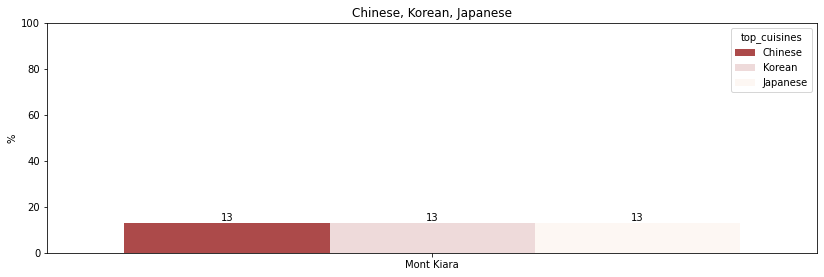

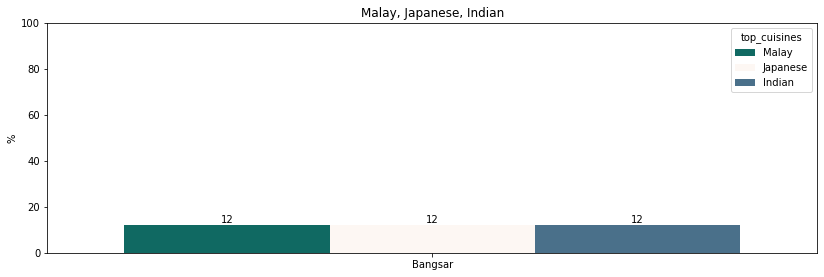

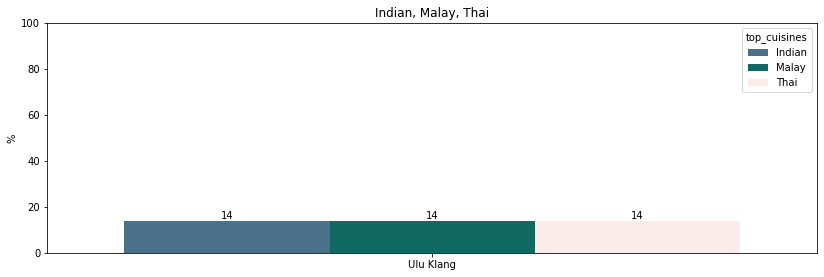

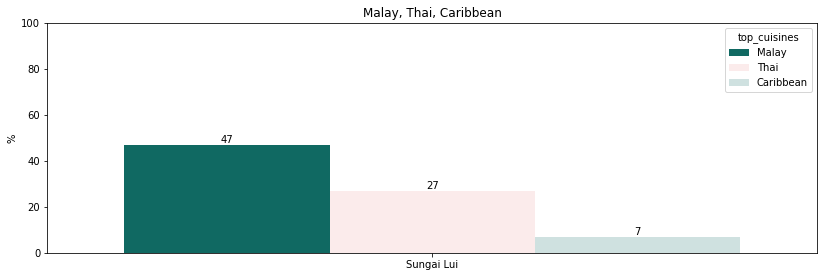

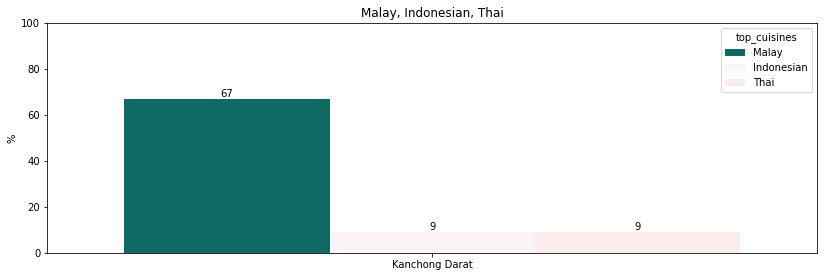

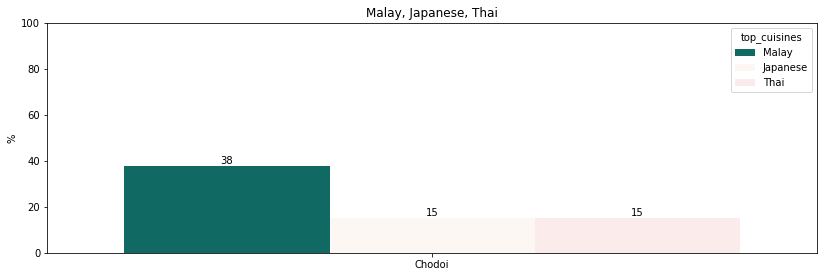

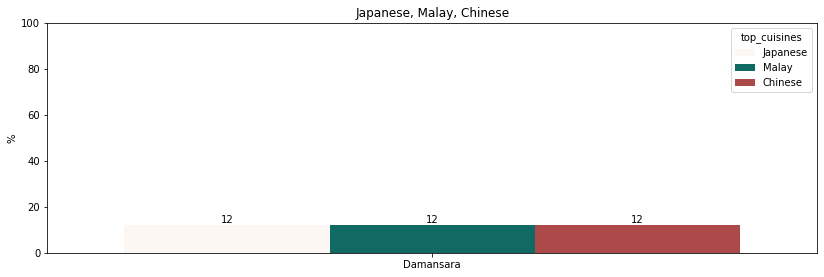

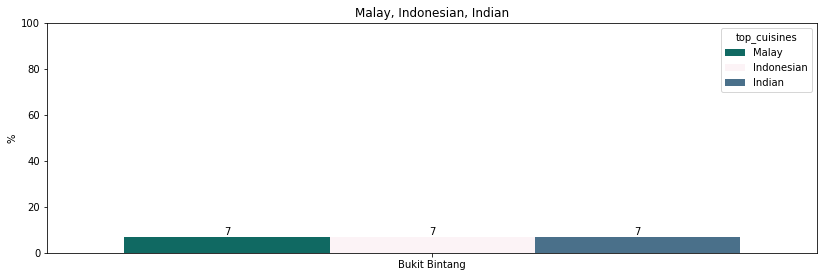

In [49]:
# Define color palette for each cuisine. 
# Darker ones correspond to Malay, Chinese and Indian.
# Light ones are foreign cuisines.
palette = {'Malay':'#01786f',
           'Chinese':'#bd3939',
           'Indian':'#407294',
           'Pakistani':'#f0f6f5',
           'Thai':'#fee9e8',
           'Indonesian':'#fdf2f6',
           'Afghan':'#c0dec7',
           'English':'#d0f2f2',
           'Portuguese':'#eff4f8',
           'Japanese':'#fff7f1',
           'Korean':'#f1d7d7',
           'Caribbean':'#cce4e2'}

# Do a loop for each unique top 3 cuisine combination for each plot.
# Then, do another loop to plot each neighborhood into the respective
# top 3 cuisine combination plot
for i in enumerate(unique_top3):
    viz = pd.DataFrame(columns=['subdistrict', 'top_cuisines', '%'])
    subdistricts = top3_cuisines_wide[top3_cuisines_wide['combine'] == i[1]]['subdistrict'].tolist()
    for j in subdistricts:
        top3_cuisines_long_subdist = top3_cuisines_long[top3_cuisines_long['subdistrict'] == j]
        viz = viz.append(top3_cuisines_long_subdist)
    plt.figure(figsize=(80,60))
    plt.subplot(12, 5, i[0]+1)
    ax = sns.barplot(data=viz, x='subdistrict', y='%', hue='top_cuisines', ci=None, palette=palette)
    plt.title(i[1])
    plt.ylim([0,100])
    plt.xlabel('')
    if len(viz['subdistrict'].unique().tolist()) >= 5:
        plt.xticks(rotation=45)
    else:
        plt.xticks(rotation=360)
    for a in ax.containers:
        ax.bar_label(a);

---

<a id='k-means'></a>
## K-means clustering

K-means clustering is an unsupervised machine learning technique that clusters data points together based on characteristics deemed similar by the algorithm.

It has its pros - in that it is a fairly quick run as it does not involve a lot of computation in the first place. However, it also has its cons - in that you would need to select the number of centroids (k) to cluster your data points with. In addition, K-means clustering may also produce slightly inconsistent results as the algorithm starts off with the random placements of centroids. This means that every new round of cluster iteration is built on from the differently placed starting centroids. K-means is also sensitive to outliers, which may be avoided by using K-median clustering. 

Before I implement K-means clustering on my dataset, I would need to do the following:

- Scale my features such that they have the properties of a standard normal distribution with a mean of 0 and a standard deviation of 1. Although...I don't think scaling my features of this particular dataset would make a huge difference to the clustering results, given that my features are...of the same scale - they are merely frequencies/ counts of restaurants. (I may be wrong though!)

- [Principal Component Analysis](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) (PCA), which I will use to reduce the number of input features/ dimensions to feed the algorithm with. I reduce my 30 dimensional space dataset to a 2 dimensional space (2 principal components). My principal components explain about 75% of the information/ variance.

In [50]:
final_df = count_df.copy()
final_df.drop(['districts','country','address','latitude','longitude',
                           'nearest_subdist','min_distance_m','dup'], axis=1, inplace=True)

In [51]:
# Scale features
X = final_df.drop(['subdistricts'], axis=1).values
y = final_df['subdistricts'].values

X = StandardScaler().fit_transform(X)

In [52]:
# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDF = pd.DataFrame(data=principalComponents)

print(f"Components: {pca.n_components_}\nTotal explained variance: {round(pca.explained_variance_ratio_.sum(),5)}")

Components: 2
Total explained variance: 0.75667


In [53]:
print('\n')

**<u>Elbow Method</u>**

As mentioned before, the downside with K-means clustering is that one needs to decide on the number of centroids (number of clusters) to train the algorithm with. The [Elbow Method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) is one way of determining this value where it calculates the distortion and inertia values for the specified number of clusters. These metrices are based on the distances between data points and their closest cluster centroids.  

From the plots below, it looks like 4 is the optimal number of centroids to use. After 4, the distortion and inertia values start decreasing linearly at a relatively constant fashion.

In [54]:
# Calculate distortion and inertia values
distortions = []
inertias = []
mapping = {}
mapping2 = {}

K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    y_predict = kmeanModel.fit(X)
    distortion = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ X.shape[0]
    inertia = kmeanModel.inertia_
    distortions.append(distortion)
    inertias.append(inertia)
    mapping[k] = distortion
    mapping2[k] = inertia

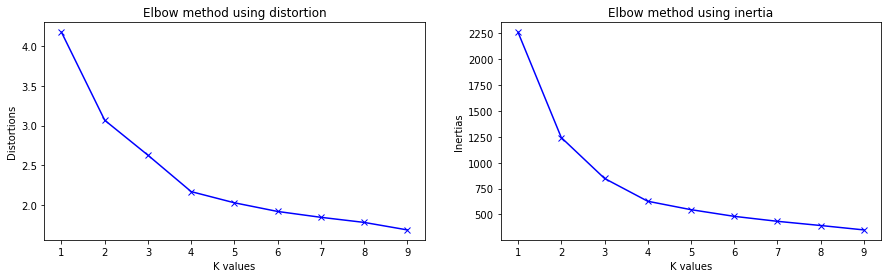

In [55]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('K values')
plt.ylabel('Distortions')
plt.title('Elbow method using distortion')

plt.subplot(1, 2, 2)
plt.plot(K, inertias, 'bx-')
plt.xlabel('K values')
plt.ylabel('Inertias')
plt.title('Elbow method using inertia');

In [56]:
print('\n')

**<u>Fit K-means clustering algorithm</u>**

Finally, we use k=4 to perform the K-means clustering and we visualise the newly clustered neighborhoods on another Folium map.

In [57]:
# Instantiate and Fit
kmeanModel = KMeans(n_clusters=4, random_state=1)
clusters = kmeanModel.fit_predict(X)

# Label clusters
count_df['label'] = clusters

In [58]:
# color map labels

color_dict = {0:'blue', 1:'green', 2:'lightpurple', 3:'red'}

map_f3 = folium.Map()

for i,j in count_df.iterrows():
    folium.CircleMarker([j['latitude'], j['longitude']], 
#                   popup=j['subdistricts'],
                  color='b',
                  fill_color=color_dict[j['label']],
                  fill=True,
                  fill_opacity=1,
                  radius=7).add_to(map_f3)
    
sw = count_df[['latitude','longitude']].min().values.tolist()
ne = count_df[['latitude','longitude']].max().values.tolist()

map_f3.fit_bounds([sw, ne])
map_f3  

From the map above, we see clear clusters that are generally based on their proximity to KL City Centre - where the green dots are concentrated at. Therefore, we can refer to each cluster based on their proximity to the city centre:

- **<font color='purple'>Bukit Bintang cluster</font>**, which is smack in the middle of the city centre. The grouped bar charts earlier show that Bukit Bintang has the lowest proportions of top 3 cuisines (7% of Malay, Indonesian, and Indian cuisines respectively), which may suggest a higher diversity of cuisines in this area.
- **<font color='green'>KLCC cluster</font>** where neighborhoods are within the city centre itself.
- **<font color='red'>Outside KLCC cluster</font>** where neighborhoods are immediately outside of the city center.
- **<font color='blue'>Outskirt cluster</font>** where neighborhoods are generally the furthest away from the city centre. 

We see several exceptions in the clusters, for example Rawang (red dot to the north). It extends to the Outskirt cluster but was clustered in another group.

A downside with K-means clustering is that while it is able to cluster similar data points together, it does not tell us by what attributes the clusters are based on. In other words, what factors contribute to the different clusters? It does not tell us. But let us try to study these factors anyway.



In [59]:
print('\n')

**<u>Delving deeper</u>**

Let's look specifically at 4 indicators:

**1) Number of restaurants**
- This is literally the sum of restaurants across all cuisines in each neighborhood.

**2) Cuisine diversity**
- Cuisine diversity refers to the number of *unique* cuisines that are available in each neighborhood.

**3) Cuisine dominance** 
- The idea behind gauging how dominating a cuisine is, is by looking at the distribution of restaurants across all cuisines that are available in the neighborhood. In other words, are there certain cuisines that dominate the neighborhood's restaurant scene? 

- I had intially thought of gauging cuisine dominance by simply calculating the standard deviation of each row (ie the data points would be the number of restaurants of each cuisine available in a neighborhood), given that the standard deviation measures the spread/ dispersion of a dataset relative to the mean. However, I am looking at categorical data (number of restaurants across different cuisines) rather than continuous data. 

- So, I will be gauging cuisine dominance by adapting the [Chi-Square test formula](https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223), which compares the expected counts in each categorical variable (if no relationship exists between the categorical variables ie every available cuisine in a neighborhood is expected to have an equal number of restaurants), with the actual observed counts. Meaning, the higher the Chi-Square value, the more concentrated/ dominating certain cuisines are over the other cuisine offerings.

**4) Ratio of foreign to local (Malay, Chinese, Indian) cuisines**
- Calculated by dividing the sum of restaurants belonging to foreign cuisines by sum of restaurants belonging to local cuisines.

Below, I show how I calculated each indicator.


In [60]:
print('\n')

**<u>Number of restaurants</u>**

In [61]:
# drop certain features from count_df
count_df.drop(['districts','country','address','nearest_subdist','min_distance_m','dup',
               'latitude','longitude'], axis=1, inplace=True)
count_df.set_index(['subdistricts','label'], inplace=True)

In [62]:
# Sum up restaurants in each neighborhood
count_df['supply'] = count_df.apply(lambda x: (x.sum()).astype(int), axis=1)
metric1 = count_df[['supply']]
metric1.head()

,,supply
subdistricts,label,
Selayang,3,315
Rawang,3,219
Taman Templer,0,7
Kundang,0,23
Kajang,3,436


In [63]:
print('\n')

**<u>Cuisine diversity</u>**

In [64]:
# Get number of unique cuisines
count_df.drop(['supply'], axis=1, inplace=True)
metric2 = (count_df != 0).sum(axis=1).to_frame().rename(columns={0:'diversity'})
metric2.head()

,,diversity
subdistricts,label,
Selayang,3,21
Rawang,3,16
Taman Templer,0,4
Kundang,0,6
Kajang,3,23


In [65]:
print('\n')

**<u>Cuisine dominance</u>**

The lowest dominance score is 0. These are for Kampung Kuantan, Simpang 3, and Bukit Belimbing. 

In each of these neighborhoods is only 1 type of cuisine that is being offered.

In [66]:
# # Define function to calculate Chi^2 scores
# def chi2(input_list):
#     chi2 = []
#     for observed in input_list:
#         # Get expected number of restaurants across cuisines if all
#         # cuisines are equal in supply
#         expected = np.sum(input_list)/len(input_list)
#         # Calculate Chi^2 value for each categorical variable (cuisine)
#         chi2.append(((observed-expected)**2)/expected)
#     # Sum all Chi^2 values 
#     total_chi2 = np.sum(chi2)/np.sum(input_input)
#     return total_chi2

In [67]:
# Define function to calculate dominance scores
def calculate_dominance(input_list):
    scores = []
    for observed in input_list:
        # Get expected number of restaurants across cuisines if all
        # cuisines are equal in supply
        expected = np.sum(input_list)/len(input_list)
        # Calculate score for each categorical variable (cuisine)
        scores.append(((observed-expected)**2)/expected)
    # Sum all scores
    total_dominance = np.sum(scores)/len(input_list)
    return total_dominance

In [68]:
# Apply function to every neighborhood
dominance = []

for i in range(0, len(count_df)):
    # Get all restaurant number values in each row
    row = count_df.iloc[i,:].tolist()
    # Remove cuisines with 0 restaurants
    row_processed = [i for i in row if i != 0]
    results = calculate_dominance(row_processed)
    dominance.append(results)
    
count_df['dominance'] = dominance
metric3 = count_df[['dominance']]
metric3.head()

,,dominance
subdistricts,label,
Selayang,3,53.993651
Rawang,3,38.855879
Taman Templer,0,0.107143
Kundang,0,2.384058
Kajang,3,49.148983


In [69]:
print('\n')

**<u>Ratio of international to local cuisines</u>**

In [70]:
local = ['Malay', 'Chinese', 'Indian']
international = count_df.columns[~count_df.columns.isin(local)].tolist()

local_sum_df = count_df[local].sum(axis=1).to_frame().rename(columns={0:"sum_local"})
international_sum_df = count_df[international].sum(axis=1).to_frame().rename(columns={0:"sum_international"})

metric4 = pd.concat([local_sum_df, international_sum_df], axis=1)
metric4['ratio_int2local'] = (metric4['sum_international']/metric4['sum_local']).values
metric4.drop(['sum_local', 'sum_international'], axis=1, inplace=True)

metric4.head()

,,ratio_int2local
subdistricts,label,
Selayang,3,0.597375
Rawang,3,0.516799
Taman Templer,0,0.776786
Kundang,0,0.586504
Kajang,3,0.796848


In [71]:
metric_count_df = pd.concat([metric1, metric2, metric3, metric4], axis=1)
metric_count_df.reset_index(inplace=True)

metric_count_df = pd.merge(left=metric_count_df, right=locations_final[['subdistricts','latitude','longitude']],
         on='subdistricts')
metric_count_df.head()

,subdistricts,label,supply,diversity,dominance,ratio_int2local,latitude,longitude
0,Selayang,3,315,21,53.993651,0.597375,3.253712,101.653901
1,Rawang,3,219,16,38.855879,0.516799,3.318847,101.574983
2,Taman Templer,0,7,4,0.107143,0.776786,3.297962,101.637427
3,Kundang,0,23,6,2.384058,0.586504,3.283333,101.516670
4,Kajang,3,436,23,49.148983,0.796848,2.983234,101.790659


In [72]:
print('\n')

Now that we have our 4 indicators, let's visualise them on maps. The color gradient is applied similarly across all layers of the map whereby the brighter the color of the data point, the higher the indicator.

Each circle on the map may be clicked on for more information. You may also look at how neighborhoods fare in each of the 4 indicators by playing around with the options legend to the top right of the map.

In [73]:
basemap = folium.Map(tile='openstreetmap')

tooltip = 'Click for subdistrict name'

# Create first layer of map showing number of restaurants
map1 = folium.FeatureGroup(name='Number of restaurants')
map1.add_to(basemap)

colormap1 = cm.LinearColormap(colors=['black','blue'], 
                           index=[metric_count_df['supply'].min(), metric_count_df['supply'].max()], 
                           vmin=metric_count_df['supply'].min(), vmax=metric_count_df['supply'].max())


for i,j in metric_count_df.iterrows():
    folium.CircleMarker(
        location=(j['latitude'], j['longitude']), 
        popup= folium.Popup(j['subdistricts'] + '<br>' + '<br>' + 'No. restaurants: ' + "{:,}".format(j['supply']),
                    max_width=450),
        tooltip=tooltip,
        radius=6,
        fill_opacity=1,
        fill=True,
        color=colormap1(j['supply'])).add_to(map1)
    
# Create second layer of map showing cuisine diversity
map2 = folium.FeatureGroup(name='Cuisine diversity')
map2.add_to(basemap)

colormap2 = cm.LinearColormap(colors=['black','yellow'], 
                           index=[metric_count_df['diversity'].min(), metric_count_df['diversity'].max()], 
                           vmin=metric_count_df['diversity'].min(), vmax=metric_count_df['diversity'].max())


for i,j in metric_count_df.iterrows():
    folium.CircleMarker(
        location=(j['latitude'], j['longitude']), 
        popup= folium.Popup(j['subdistricts'] + '<br>' + '<br>' + 'Diversity score: ' + str(round(j['diversity'],1)),
                    max_width=450),
        tooltip=tooltip,
        radius=6,
        fill_opacity=1,
        fill=True,
        color=colormap2(j['diversity'])).add_to(map2)

# Create third layer of map showing cuisine dominance
map3 = folium.FeatureGroup(name='Cuisine dominance')
map3.add_to(basemap)

colormap3 = cm.LinearColormap(colors=['black','orange'], 
                           index=[metric_count_df['dominance'].min(), metric_count_df['dominance'].max()], 
                           vmin=metric_count_df['dominance'].min(), vmax=metric_count_df['dominance'].max())


for i,j in metric_count_df.iterrows():
    folium.CircleMarker(
        location=(j['latitude'], j['longitude']),
        highlight=True,
        popup= folium.Popup(j['subdistricts'] + '<br>' + '<br>' + 'Dominance score: ' + str(round(j['dominance'],1)),
                    max_width=450),
        tooltip=tooltip,
        radius=6,
        fill_opacity=1,
        fill=True,
        color=colormap3(j['dominance'])).add_to(map3)
    
# Create forth layer of map showing cuisine ratio
map4 = folium.FeatureGroup(name='Int:local cuisine ratio')
map4.add_to(basemap)

colormap4 = cm.LinearColormap(colors=['black','red'], 
                           index=[metric_count_df['ratio_int2local'].min(), metric_count_df['ratio_int2local'].max()], 
                           vmin=metric_count_df['ratio_int2local'].min(), vmax=metric_count_df['ratio_int2local'].max())


for i,j in metric_count_df.iterrows():
    folium.CircleMarker(
        location=(j['latitude'], j['longitude']), 
        popup= folium.Popup(j['subdistricts'] + '<br>' + '<br>' + 'Ratio: ' + str(round(j['ratio_int2local'],1)),
                            max_width=450),
        tooltip=tooltip,
        radius=6,
        fill_opacity=1,
        fill=True,
        color=colormap4(j['ratio_int2local'])).add_to(map4)
    
# Create fifth layer of map showing all clusters
map5 = folium.FeatureGroup(name='Neighborhood clusters')
map5.add_to(basemap)

colordict = {0:'blue', 1:'green', 2:'lightpurple', 3:'red'}

for i,j in metric_count_df.iterrows():
    folium.CircleMarker([j['latitude'], j['longitude']], 
                  popup=j['subdistricts'],
                  tooltip=tooltip,
                  color='b',
                  fill_color=colordict[j['label']],
                  fill=True,
                  fill_opacity=1,
                  radius=7).add_to(map5)
    
sw2 = metric_count_df[['latitude','longitude']].min().values.tolist()
ne2 = metric_count_df[['latitude','longitude']].max().values.tolist()

basemap.fit_bounds([sw2, ne2])

folium.LayerControl(collapsed=False).add_to(basemap)

basemap

Some observations that we can make from the maps are:

1) Generally, the further away neighborhoods are from the city center, the lower they scored in all four indicators. For example, the further away a neighborhood is from the city center, the lower the number of restaurants, as well as its cuisine diversity, dominance, and 'internationality' of available cuisines.

2) Neighborhoods that are within the city center itself (**<font color='green'>KLCC cluster</font>** and **<font color='purple'>Bukit Bintang cluster</font>**) have a distinctly  higher number of restaurants and ratio of international to local cuisines, as compared to neighborhoods outside the city center (**<font color='red'>Outside KLCC cluster</font>** and **<font color='blue'>Outskirt cluster</font>**).

3) Meanwhile, high cuisine diversity and dominance seem to be characteristic of the 3 clusters that are closest to the city center. Neighborhoods in the Outskirt cluster ranked lowest in cuisine diversity and dominance.


---

<a id='conclusion'></a>
## Conclusion

This analysis has seen me acquire data through web scraping and API requests from Wikipedia and Foursquare; geocode locations data with Geopy; and preprocess data into formats that are desirable for visualisation and analysis. K-means clustering was employed using the Elbow Method to determine the number of optimal clusters, which then got me 4 neighborhood clusters that seemed to reflect their respective promixities to the city center. Upon further investigation, it seems like clusters that are within the city center itself (KLCC and Bukit Bintang clusters) have a much higher number of restaurants and specifically, international-cuisine restaurants than local ones, as compared to the Outside KLCC and Outskirt clusters. On the other hand, all clusters except the Outskirt cluster have high rankings in their cuisine diversity and dominance. To put it another way, there is a distinction in the number of restaurants and the ratio of international to local cuisines BETWEEN clusters that are in the city center itself, AND clusters that are outside the city center. Meanwhile, the distinction in cuisine diversity and dominance seem to be more diluted. 


**Limitations**

This exercise is dependent on the cleanliness of the restaurant cuisine data. Wrongly categorised cuisines or venues would most definitely lead to an inaccurate representation of cuisines across neighborhoods of our geographical coverage. As discussed earlier in the post, there are indeed restaurants with wrongly tagged categories.

Another thing to note is that K-means clustering is affected heavily by outliers, which is something that I did not check prior to implementing the cluster. 

Some things that I would like to explore further in the future is the incorporation of Kopitiam and Mamak stores, both categories of which may be found on Foursquare. Kopitiams and Mamaks are essentially non-restaurant food places that are generally more informal in setting and most probably cheaper in pricing than an average restaurant. Reason for my wanting to include these food places in the analysis is that Malaysia has a lot of Kopitiams and Mamaks, and my food-based neighborhood segmentation analysis does not feel complete without the inclusion of food places that are pretty much characteristic of Malaysia's food scene. Similarly, depending on how wide we want the scope of analysis to be, the data input or features may be modified accordingly (such as the popularity of food places, the average pricing etc). Chloropeth maps may be used to visualise the neighborhoods too. 

Til next time!

In [ ]:
# to remove code cells from being seen in html: https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook

from traitlets.config import Config
import nbformat as nbf
from nbconvert.exporters import HTMLExporter
from nbconvert.preprocessors import TagRemovePreprocessor

# Setup config
c = Config()

# Configure tag removal - be sure to tag your cells to remove  using the
# words remove_cell to remove cells. You can also modify the code to use
# a different tag word
c.TagRemovePreprocessor.remove_cell_tags = ("remove_cell",)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
c.TagRemovePreprocessor.remove_input_tags = ('remove_input',)
c.TagRemovePreprocessor.enabled = True

# Configure and run out exporter
c.HTMLExporter.preprocessors = ["nbconvert.preprocessors.TagRemovePreprocessor"]

exporter = HTMLExporter(config=c)
exporter.register_preprocessor(TagRemovePreprocessor(config=c),True)

# Configure and run our exporter - returns a tuple - first element with html,
# second with notebook metadata
output = HTMLExporter(config=c).from_filename("Visualising restaurant cuisine diversity across Malaysia's neighbourhoods.ipynb")

# Write to output html file
with open("entry14.html",  "w") as f:
    f.write(output[0])